In [1]:
from utils import keys_to_counts, get_keys

In [2]:
import pandas as pd

data_path = "D:\\studium\\analyse\\data_prep\\src\\_2_preproc_pipeline_en\\data_preprocessed\\2_tokenize_ch_en.csv"
df = pd.read_csv(data_path)

In [3]:
df.head()

,id,pub_year,text_preproc2
0,WO002024093209A1,2024,method dynamic target tracking legged disclose...
1,WO002024093550A1,2024,operation maintenance comprise operation maint...
2,WO002024093218A1,2024,maintenance base station cleaning system maint...
3,WO002024092854A1,2024,control method swimming pool cleaning mean mea...
4,WO002024092922A1,2024,teaching method apparatus electronic device st...


In [13]:
# vectorize the text data with tf-idf
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=40, max_df=0.8)

x_vec = vectorizer.fit_transform(df['text_preproc2'])

In [14]:
vectorizer.get_feature_names_out().__len__()

1926

In [15]:
# Define Search Param
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV


search_params = {
    'n_components': [n for n in range(6, 12, 2)],
    'learning_decay': [i/10 for i in range(2, 8, 2)]
}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50., random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(x_vec)

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 learning_offset=50.0,
                                                 max_iter=5, random_state=0),
             param_grid={'learning_decay': [0.2, 0.4, 0.6],
                         'n_components': [6, 8, 10]})

In [16]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(x_vec))

Best Model's Params:  {'learning_decay': 0.6, 'n_components': 8}
Best Log Likelihood Score:  -2376048.409351775
Model Perplexity:  424.4352445351125


#### 1
```
Best Model's Params:  {'learning_decay': 0.6, 'n_components': 10}
Best Log Likelihood Score:  -2506177.393882964
Model Perplexity:  460.5684298118633

vectorizer = CountVectorizer(min_df=20, max_df=0.9)
```

#### 2
```
Best Model's Params:  {'learning_decay': 0.6, 'n_components': 8}
Best Log Likelihood Score:  -2376048.409351775
Model Perplexity:  424.4352445351125

vectorizer = CountVectorizer(min_df=40, max_df=0.8)
```



In [17]:
lda_output = best_lda_model.transform(x_vec)

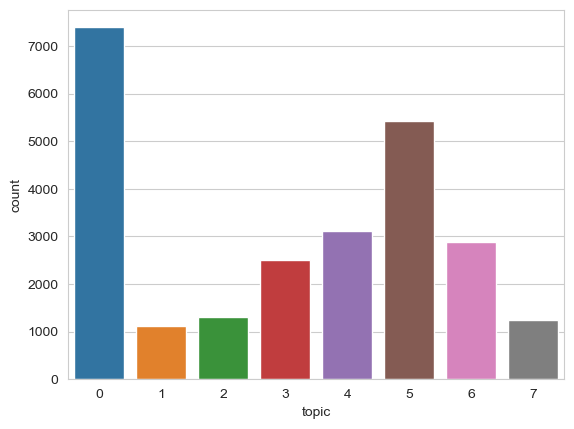

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

lda_keys = get_keys(lda_output)
lda_categories, lda_counts = keys_to_counts(lda_keys)

topics_df_lda = pd.DataFrame({'topic' : lda_categories, 'count' : lda_counts})
sns.barplot(x=topics_df_lda['topic'], y = topics_df_lda['count'])
plt.show()

In [19]:
import numpy as np

# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,connect,arrange,plate,body,end,mount,rod,mechanism,support,base,device,assembly,utility,fix,rotate
Topic 1,cleaning,clean,sweeping,station,body,air,base,dust,assembly,floor,cavity,provide,box,arrange,device
Topic 2,arm,joint,end,mechanical,device,second,force,axis,control,surgical,fire,tool,tail,provide,grab
Topic 3,method,system,position,point,base,model,image,coordinate,obtain,positioning,laser,pose,accord,datum,invention
Topic 4,drive,wheel,mechanism,body,assembly,connect,walk,arrange,structure,motor,chassis,driving,type,leg,rotate
Topic 5,method,target,accord,control,information,path,position,device,step,medium,invention,storage,determine,obtain,area
Topic 6,control,module,system,charge,unit,signal,intelligent,invention,information,device,datum,communication,operation,base,controller
Topic 7,inspection,detection,water,body,underwater,device,pipeline,camera,arrange,spray,tank,power,disinfection,high,maintenance


In [20]:
#this is by far the easiest way to load a pre-trained sklearn lda model onto pyLDAvis
#there are other means of using this visible on pyLDAvis' main repo

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

feature_names = vectorizer.get_feature_names_out()

vectorizer.get_feature_names = lambda: feature_names

display_data = pyLDAvis.sklearn.prepare(best_lda_model, #our pre-trained LDA model
                         x_vec, #this gives us our document-term matrix
                        vectorizer) #the vectoriser object
                        
pyLDAvis.display(display_data)  

C:\Users\paul-\anaconda3\envs\ml_angew_programm\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
